A continuación se muestra una matriz de expresión genética:

In [1274]:
genexp<-read.csv("practica/GEMatrixFiltered.csv")
head(genexp)

X,X212284_x_at,X212869_x_at,X213614_x_at,X212391_x_at,X201257_x_at,AFFX.hum_alu_at,X206559_x_at,X214003_x_at,X208755_x_at,⋯,X214981_at,X216660_at,X217101_at,X218922_s_at,X203953_s_at,X221755_at,X208278_s_at,X207162_s_at,X206824_at,X218840_s_at
Normal.BC0043N,9167.03,7380.27,8341.82,7944.99,8367.28,7884.22,6209.89,6009.60,9017.07,,13.9187,30.9902,26.8305,30.6226,13.6677,23.7455,29.1401,23.8904,64.3171,25.5825
Cancer.BC0043T,10635.90,11010.80,9859.02,10493.60,10805.70,8507.10,9060.41,9426.21,8674.11,,17.2673,56.3875,16.9442,14.5954,15.2555,19.2764,16.4308,26.5672,53.7115,28.7201
Normal.BC0051N,8015.29,6112.62,8287.92,7360.60,7060.93,8003.40,7140.51,6029.11,7026.17,,26.6429,29.1446,23.8505,32.2064,15.9346,27.4183,21.6383,21.3962,27.9609,45.1721
Cancer.BC0051T,9081.20,8925.35,8276.54,9021.02,8622.68,8925.17,7862.39,6847.31,9651.01,,37.5716,30.0083,20.7826,22.1020,27.5567,26.4899,26.3171,16.6457,41.5037,25.8667
Normal.BC0057N,9006.52,8338.44,7069.53,7909.77,7348.80,7966.06,7120.25,7903.76,7387.18,,36.4167,29.9436,45.3716,31.1614,31.3397,32.0059,29.1746,21.2647,34.7236,35.4706
Cancer.BC0057T,8307.87,7295.69,7048.75,7111.87,6372.62,8056.31,6406.97,6256.54,7098.11,,21.3444,54.1291,37.4840,22.2405,50.9866,26.8458,33.2448,18.3316,24.6310,24.8679


In [1275]:
ncol(genexp)
nrow(genexp)


[1] 482

[1] 86

### Limpieza de datos:

* Normalizar
* ¿Existen outliers? Tratamiento de Outliers

In [1276]:
#summary(genexp)
## Dividimos nuestros datos en "test" y "training". Usamos semilla para hacerlo reproducible
set.seed(123)

## Usamos comando sample para seleccionar de forma aleatoria un índice y luego lo utilizamos para dividir los datos en
## en training y test.
indexes = sample(1:nrow(genexp), size=0.2*nrow(genexp))

test = genexp[indexes,]
train = genexp[-indexes,]

In [1357]:
## Normalización
library(pracma) 
mnCols<-repmat(colMeans(data.matrix(train)),n = nrow(train),m=1)
sdCols<-repmat(sapply(train, sd,na.rm=T),n = nrow(train),m=1)
train_normalizado<-(train-mnCols)/sdCols
test_normalizado<-(test-mnCols[1:nrow(test),])/sdCols[1:nrow(test),]

train_normalizado$X <- train$X
test_normalizado$X <- test$X

train_normalizado_bck<-train_normalizado #=>copia de seguridad

Warning message in var(if (is.vector(x) || is.factor(x)) x else as.double(x), na.rm = na.rm):
"Calling var(x) on a factor x is deprecated and will become an error.
  Use something like 'all(duplicated(x)[-1L])' to test for a constant vector."Warning message in Ops.factor(left, right):
"'-' not meaningful for factors"Warning message in Ops.factor(left, right):
"'-' not meaningful for factors"

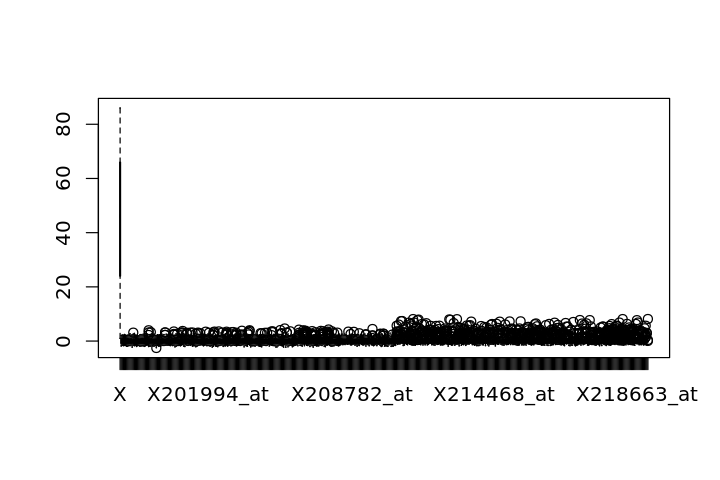

In [1278]:
boxplot(train_normalizado)

In [1279]:
# OUTLIER
#Borramos los outliers
for (i in 1:ncol(train_normalizado)){
    x <- train_normalizado[,i]
    qnt  <- quantile(as.numeric(x), probs=c(.25, .75), na.rm = T)
    caps <- quantile(as.numeric(x), probs=c(.1, .90), na.rm = T)    
    H <- 10 * IQR(x, na.rm = T)
    x[x < (qnt[1] - H)] <- caps[1]
    x[x > (qnt[2] + H)] <- caps[2]
    train_normalizado[,i]<-x
}

Warning message in `[<-.factor`(`*tmp*`, x < (qnt[1] - H), value = structure(10.8, .Names = "10%")):
"invalid factor level, NA generated"Warning message in Ops.factor(x, (qnt[1] - H)):
"'<' not meaningful for factors"Warning message in `[<-.factor`(`*tmp*`, x > (qnt[2] + H), value = structure(77.2, .Names = "90%")):
"invalid factor level, NA generated"Warning message in Ops.factor(x, (qnt[2] + H)):
"'>' not meaningful for factors"

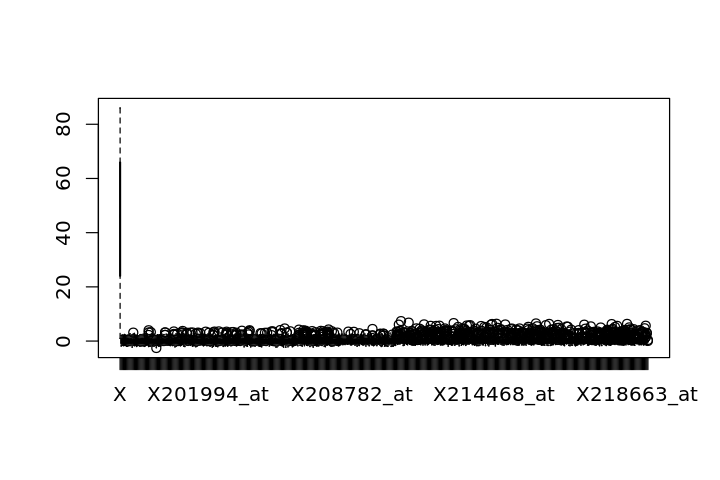

In [1280]:
boxplot(train_normalizado)

### Parte 1
Realizar un modelo de regresión logistica que sea capaz de, dada la expresión genética de 482 genes realice una predicción de si el tejido es canceroso o no:
* Pintar curva ROC
* Para un umbral de 0 calcular:
 * Precisión
 * F0.5
 * Exactitud
 * Exhaustividad
 * Matriz de confusión
 

In [1281]:
### REGRESIÓN LOGÍSTICA
#head(train_normalizado)
train_normalizado$X <- as.character(train_normalizado$X)
train_normalizado$X[grepl('Cancer.*', train_normalizado$X)] <- "1" #=>Si contiene "Cancer" = True => ponemos valor 1
train_normalizado$X[grepl('Normal.*', train_normalizado$X)] <- "0" #=>Si contiene "Normal" = True => ponemos valor 0
train_normalizado$X<-factor(train_normalizado$X)

model<-glm(formula = X ~ ., family = binomial(link = "logit"), data = train_normalizado)
betalg<-model$coefficients
betalg

(Intercept)            X212284_x_at            X212869_x_at 
              -1.925079             -397.104070               10.444426 
           X213614_x_at            X212391_x_at            X201257_x_at 
            -136.574106               -6.937482             -149.138258 
        AFFX.hum_alu_at            X206559_x_at            X214003_x_at 
            -188.814808              193.167235              214.504136 
           X208755_x_at            X200062_s_at            X201429_s_at 
              15.363003               -2.628243              -99.294141 
           X213828_x_at            X200717_x_at            X201891_s_at 
            -180.248392              273.119080             -122.593227 
           X213477_x_at            X213080_x_at              X200633_at 
             130.887040             -611.426092              183.298090 
             X200926_at            X200933_x_at            X213583_x_at 
             221.227349              503.916093              -14.298340 
           X204892_x_at            X201492_s_at            X200095_x_at 
            -325.330719              171.232931              392.814249 
           X208695_s_at            X207783_x_at               X71933_at 
               3.345757               51.050102              332.103219 
           X200016_x_at            X200741_s_at               X396_f_at 
            -124.391511              -23.109860               -6.098932 
           X213084_x_at            X200963_x_at            X200099_s_at 
             -10.906824               19.212320              145.452066 
           X213356_x_at            X211542_x_at            X213347_x_at 
             134.682353             -567.047035             -120.369505 
           X201217_x_at            X200032_s_at            X211978_x_at 
             320.698737               93.481484            -1749.386347 
           X201254_x_at            X200817_x_at             X33323_r_at 
             -98.069162              135.380850             -202.569194 
           X211378_x_at            X217740_x_at            X201293_x_at 
             507.634281              -84.337482               52.658960 
           X211073_x_at            X221607_x_at            X212661_x_at 
             121.515199              -17.208004              799.796817 
           X208825_x_at            X215076_s_at            X213214_x_at 
              21.652704               70.629761               -2.036154 
           X214328_s_at            X212039_x_at            X201033_x_at 
             -21.315160                4.948755             -155.468254 
           X211970_x_at            X207243_s_at            X201550_x_at 
            -612.954171              -32.743089              671.641397 
             X202088_at            X211983_x_at            X200834_s_at 
            -104.264366               81.865710              -28.232803 
           X211943_x_at            X202649_x_at            X200763_s_at 
            -241.758844             -292.562610              -29.570559 
           X214749_s_at            X212988_x_at            X211765_x_at 
             130.769832              195.170984              537.863735 
           X210646_x_at              X208718_at            X201553_s_at 
              52.203391               74.287539             -198.408434 
           X200092_s_at            X208856_x_at            X219071_x_at 
                     NA                      NA                      NA 
           X200809_x_at            X208834_x_at              X200614_at 
                     NA                      NA                      NA 
           X200650_s_at            X211720_x_at            X200088_x_at 
                     NA                      NA                      NA 
           X213414_s_at            X209134_s_at              X201994_at 
                     NA                      NA                      NA 
           X212790_x_at            X201049_s_at            X200958_s_a

In [1287]:
###Matriz de confusion
train_normalizado<-train_normalizado_bck
train_normalizado$X <- as.character(train_normalizado$X)
train_normalizado$X[grepl('Cancer.*', train_normalizado$X)] <- "Cancer" #=>Si contiene "Cancer" = True => ponemos valor 1
train_normalizado$X[grepl('Normal.*', train_normalizado$X)] <- "Normal" #=>Si contiene "Normal" = True => ponemos valor 0
train_normalizado$X<-factor(train_normalizado$X)

M<-matrix(rep(0,4),ncol = 2)
y_est=factor(ifelse(predict(model,train_normalizado)< 0,0,1),labels=c("Normal", "Cancer"))

idx_normal<-train_normalizado$X=="Normal"
idx_cancer <-train_normalizado$X=="Cancer"

M[1,1]=sum(y_est[idx_normal]=="Normal")
M[1,2]=sum(y_est[idx_cancer]=="Normal")
M[2,1]=sum(y_est[idx_normal]=="Cancer")
M[2,2]=sum(y_est[idx_cancer]=="Cancer")
M

table(y_est,train_normalizado$X)

paste("Precision:", M[1,1]/(M[1,2]+M[1,1]))
paste("Exhausitivad:", M[1,1]/(M[2,1]+M[1,1]))
paste("Exactitud:",(M[1,1]+M[2,2])/sum(sum(M)))
p<-M[1,1]/(M[1,2]+M[1,1])
e<-M[1,1]/(M[2,1]+M[1,1])
b<-0
(1+b^2)*(p*e)/(b^2*p+e)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

37,0
0,32


        
y_est    Cancer Normal
  Normal      0     37
  Cancer     32      0

[1] "Precision: 1"

[1] "Exhausitivad: 1"

[1] "Exactitud: 1"

[1] 1

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message:
"Removed 2 rows containing missing values (geom_path)."

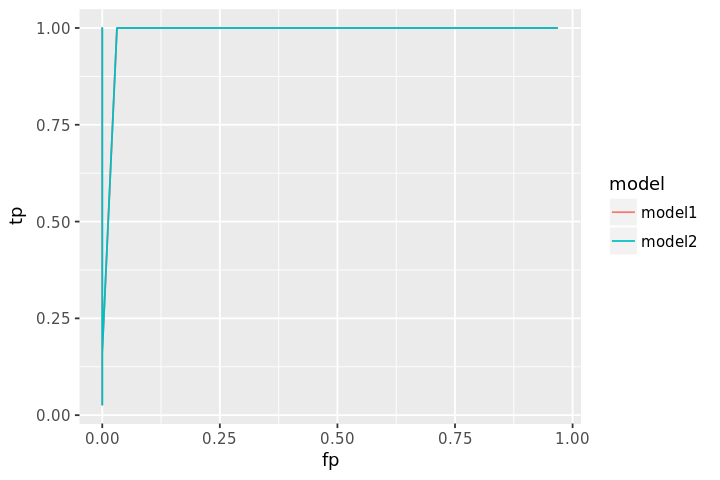

In [1288]:
### CURVA ROC
train_normalizado<-train_normalizado_bck
train_normalizado$X <- as.character(train_normalizado$X)
train_normalizado$X[grepl('Cancer.*', train_normalizado$X)] <- "1" #=>Si contiene "Cancer" = True => ponemos valor 1
train_normalizado$X[grepl('Normal.*', train_normalizado$X)] <- "0" #=>Si contiene "Normal" = True => ponemos valor 0
train_normalizado$X<-factor(train_normalizado$X)

##########
calctp_fp<-function(y_predict,y_real,th){
    y_est<-ifelse(y_predict<th,0,1)
    idx_cancer<-y_real==1
    idx_normal <-y_real==0

    M<-table(y_est,train_normalizado$X)
    if (ncol(M)==2 && nrow(M)==2){
        truePositive<-M[1,1]/(M[1,1]+M[2,1])
        falsePositive<-M[1,2]/(M[1,2]+M[2,2])
        c(tp=truePositive,fp=falsePositive)
    }else{
        c(tp=NA,fp=NA)
    }
}

y_predict<-predict(model,train_normalizado)
dfROC<-data.frame(th=unique(y_predict),tp=NA,fp=NA,model="model1")

for (i in 1:nrow(dfROC)){
    v<-calctp_fp(y_predict,train_normalizado$X,dfROC$th[i])
    dfROC$tp[i]<-v["tp"]
    dfROC$fp[i]<-v["fp"]
}

model2<-glm(formula = X ~ ., family = binomial(link = "logit"), data = train_normalizado)
#
y_predict<-predict(model2,train_normalizado)
dfROC2<-data.frame(th=unique(y_predict),tp=NA,fp=NA,model="model2")

for (i in 1:nrow(dfROC)){
    v<-calctp_fp(y_predict,train_normalizado$X,dfROC2$th[i])
    dfROC2$tp[i]<-v["tp"]
    dfROC2$fp[i]<-v["fp"]
}
dfROC<-rbind(dfROC,dfROC2)
dfROC<-dfROC[order(dfROC$fp),]
ggplot(data=dfROC,aes(x=fp,y=tp,color=model))+geom_path()

### Parte 2

Realizar clusterización por k-means y uno basado en áboles (dendrograma). ¿Cual sería el número de clusters óptimo?  ¿Puedes identificar algún cluster interesante?

In [1289]:
## Parte 2
train_normalizado<-train_normalizado_bck
train_normalizado$X <- as.character(train_normalizado$X)
train_normalizado$X[grepl('Cancer.*', train_normalizado$X)] <- "1" #=>Si contiene "Cancer" = True => ponemos valor 1
train_normalizado$X[grepl('Normal.*', train_normalizado$X)] <- "0" #=>Si contiene "Normal" = True => ponemos valor 0
train_normalizado$X<-factor(train_normalizado$X)

myclust<-kmeans(train_normalizado,3)
print("Los centroides son: ")
myclust$centers
myclust

[1] "Los centroides son: "


,X,X212284_x_at,X212869_x_at,X213614_x_at,X212391_x_at,X201257_x_at,AFFX.hum_alu_at,X206559_x_at,X214003_x_at,X208755_x_at,⋯,X214981_at,X216660_at,X217101_at,X218922_s_at,X203953_s_at,X221755_at,X208278_s_at,X207162_s_at,X206824_at,X218840_s_at
1,0.5277778,-0.7479985,-0.7579011,-0.7659768,-0.7196037,-0.6765158,-0.7183916,-0.7370992,-0.6658712,-0.5830877,,-0.2261725,0.04093563,-0.6546103,-0.6775200,-0.6172232,-0.7122822,-0.6408896,-0.3826105,-0.3625541,-0.1400347
2,0.0000000,-1.3482797,-1.5217101,-1.3469871,-1.4147330,-1.2905544,-1.9621654,-1.6869731,-1.5493465,-1.6509178,,0.5750717,0.16039331,0.6000230,-1.1400631,1.5355855,3.3119620,0.8565881,-0.3661683,-1.1601119,-0.1995217
3,0.4062500,0.8836320,0.9001922,0.9038173,0.8537645,0.8014101,0.8695082,0.8819546,0.7975222,0.7075649,,0.2364731,-0.05106487,0.7176858,0.7978369,0.6463890,0.6978187,0.6942324,0.4418796,0.4441269,0.1637741


K-means clustering with 3 clusters of sizes 36, 1, 32

Cluster means:
          X X212284_x_at X212869_x_at X213614_x_at X212391_x_at X201257_x_at
1 0.5277778   -0.7479985   -0.7579011   -0.7659768   -0.7196037   -0.6765158
2 0.0000000   -1.3482797   -1.5217101   -1.3469871   -1.4147330   -1.2905544
3 0.4062500    0.8836320    0.9001922    0.9038173    0.8537645    0.8014101
  AFFX.hum_alu_at X206559_x_at X214003_x_at X208755_x_at X200062_s_at
1      -0.7183916   -0.7370992   -0.6658712   -0.5830877   -0.7803773
2      -1.9621654   -1.6869731   -1.5493465   -1.6509178   -1.2650639
3       0.8695082    0.8819546    0.7975222    0.7075649    0.9174578
  X201429_s_at X213828_x_at X200717_x_at X201891_s_at X213477_x_at X213080_x_at
1   -0.5205492   -0.6616717   -0.6635594   -0.7469649   -0.7283578   -0.7126498
2   -2.2504484   -0.8543891   -0.9679036   -1.5334259   -2.0058238   -1.4718637
3    0.6559444    0.7710803    0.7767513    0.8882551    0.8820845    0.8477268
  X200633_at X200926_a

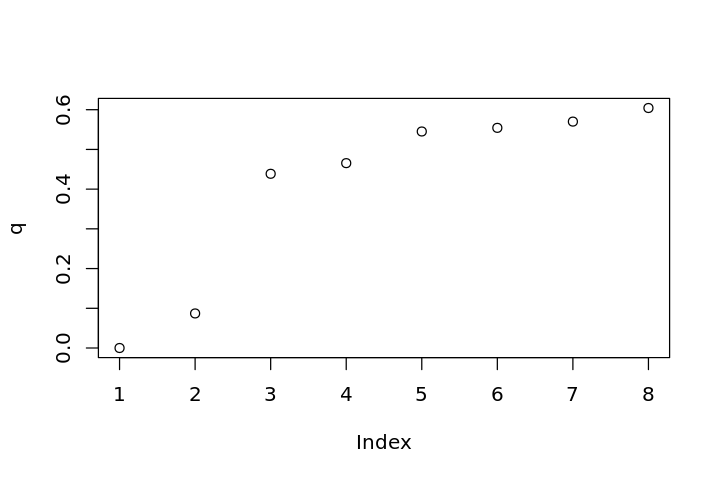

In [1290]:
#Número óptimo de clusters
q<-c()
for (k in 1:8){
    myclust<-kmeans(train_normalizado,k)
    q[k]<-myclust$betweenss/myclust$totss
}
plot(q)

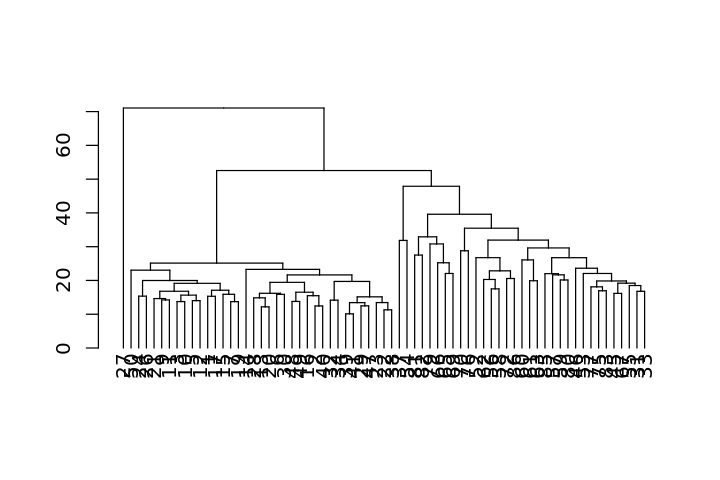

In [1291]:
#Dendrograma
d <- dist(as.matrix(train_normalizado),method = "euclidean")
hc <- hclust(d,method="complete")
hcd <- as.dendrogram(hc)
plot(hcd)

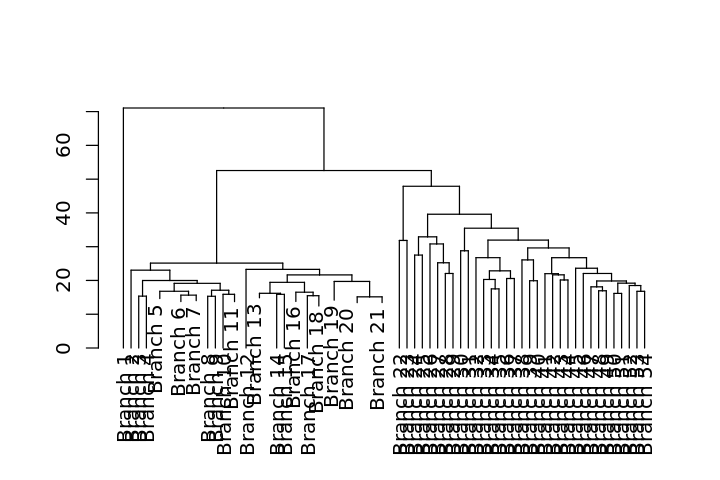

In [1293]:
plot(cut(hcd,h=15)$upper)

In [1294]:
cut(hcd,h=15)$lower

[[1]]
'dendrogram' leaf '27', at height 0 

[[2]]
'dendrogram' leaf '50', at height 0 

[[3]]
'dendrogram' leaf '24', at height 0 

[[4]]
'dendrogram' leaf '26', at height 0 

[[5]]
'dendrogram' with 2 branches and 3 members total, at height 14.64271 

[[6]]
'dendrogram' with 2 branches and 2 members total, at height 13.7493 

[[7]]
'dendrogram' with 2 branches and 2 members total, at height 14.0199 

[[8]]
'dendrogram' leaf '1', at height 0 

[[9]]
'dendrogram' leaf '17', at height 0 

[[10]]
'dendrogram' leaf '15', at height 0 

[[11]]
'dendrogram' with 2 branches and 2 members total, at height 13.73111 

[[12]]
'dendrogram' leaf '14', at height 0 

[[13]]
'dendrogram' with 2 branches and 3 members total, at height 14.86117 

[[14]]
'dendrogram' leaf '6', at height 0 

[[15]]
'dendrogram' leaf '30', at height 0 

[[16]]
'dendrogram' with 2 branches and 2 members total, at height 13.78301 

[[17]]
'dendrogram' leaf '16', at height 0 

[[18]]
'dendrogram' with 2 branches and 2 members 

In [1295]:
cutree(hc,h=15)
table(train_normalizado$X, cutree(hc,h=15))

1  2  3  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 26 27 28 29 30 
 1  2  3  4  5  6  7  3  7  4  8  9 10 11 12  6  8  7 13 13 14 15 16  8 17 18 
31 32 33 34 37 38 39 40 41 45 46 47 48 49 50 52 53 54 55 56 57 58 59 60 61 62 
19 20 21 20 22 13 17  2 17 23 24 17 25 25 26 27 28 29 30 31 32 33 34 35 36 37 
63 65 66 67 69 70 72 75 76 77 79 80 81 82 83 85 86 
38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54

   
    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
  0 1 0 1 1 0 2 3 1 0  1  0  1  1  0  0  1  4  0  1  0  1  1  1  0  1  0  0  1
  1 0 2 1 1 1 0 0 2 1  0  1  0  2  1  1  0  0  1  0  2  0  0  0  1  1  1  1  0
   
    29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
  0  0  1  0  1  0  1  0  1  0  1  1  0  1  1  0  0  1  0  1  1  0  1  0  1  1
  1  1  0  1  0  1  0  1  0  1  0  0  1  0  0  1  1  0  1  0  0  1  0  1  0  0
   
    54
  0  0
  1  1

### Parte 3

Realizar un PCA, quedarse con los dos valores más representativos. Pintarlo en una nube de puntos donde los tejidos normales tendrán un color y los tejidos con cancer otro.

A partir de esta representación simplificada (con solo 2 valores más significativos) crear un modelo de regresión logística. Compara la curva ROC de este nuevo modelo con el de la *Parte 1*

In [1354]:
## Parte 3
train_normalizado<-train_normalizado_bck
train_normalizado$X <- as.character(train_normalizado$X)
train_normalizado$X[grepl('Cancer.*', train_normalizado$X)] <- "1" #=>Si contiene "Cancer" = True => ponemos valor 1
train_normalizado$X[grepl('Normal.*', train_normalizado$X)] <- "0" #=>Si contiene "Normal" = True => ponemos valor 0
train_normalizado$X<-factor(train_normalizado$X)

t_n<-train_normalizado[,3:ncol(train_normalizado)]
prt_n<-prcomp(t_n, center=TRUE, scale. = TRUE)

temp<-train_normalizado$X

pca_data_train_norm<-as.data.frame(prt_n$x[,1:2])
pca_data_train_norm$X<-temp

idx<-sample(1:nrow(pca_data_train_norm),nrow(pca_data_train_norm)*0.7)
train<-pca_data_train_norm[idx,]
test<-pca_data_train_norm[-idx,]

model<-glm(data=pca_data_train_norm,formula = X ~ ., family = binomial(link = "logit"))

y_predict <- predict(model, test)
#y_factor<-as.factor(ifelse(y_predict<0,"B","M"))
y_factor<-as.factor(ifelse(y_predict<0, 0, 1))

table(y_factor,test$X)

        
y_factor 0 1
       0 8 3
       1 5 5

   
     1  2
  0 19 18
  1 13 19

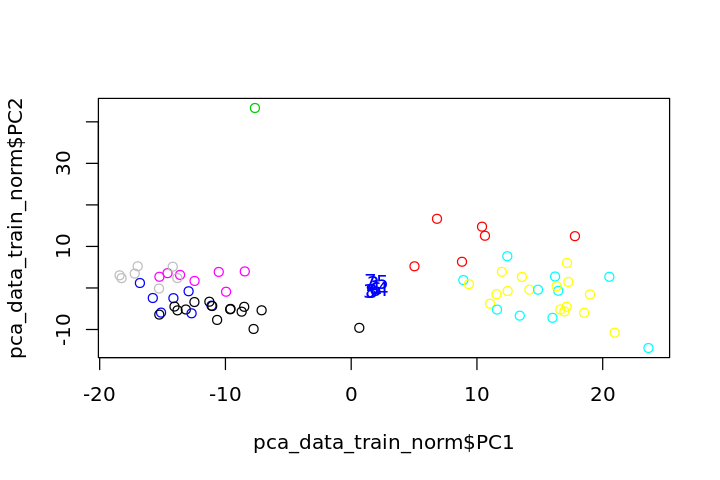

In [1355]:
my_clust<-kmeans(pca_data_train_norm[,(1:2)],2)

plot(pca_data_train_norm$PC1,pca_data_train_norm$PC2,col=myclust$cluster)
text(x=myclust$centers[,1], y=myclust$centers[,2], cex=1, pos=4, labels=(1:nrow(myclust$centers)),col="blue")

table(pca_data_train_norm$X, my_clust$cluster)

Warning message:
"Removed 2 rows containing missing values (geom_path)."

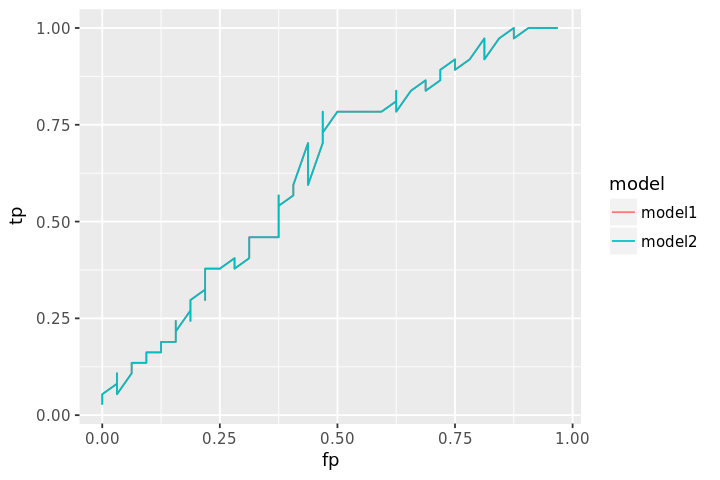

In [1356]:
calctp_fp<-function(y_predict,y_real,th){
    y_est<-ifelse(y_predict<th,0,1)
    idx_cancer<-y_real==1
    idx_normal <-y_real==0

    M<-table(y_est,pca_data_train_norm$X)
    if (ncol(M)==2 && nrow(M)==2){
        truePositive<-M[1,1]/(M[1,1]+M[2,1])
        falsePositive<-M[1,2]/(M[1,2]+M[2,2])
        c(tp=truePositive,fp=falsePositive)
    }else{
        c(tp=NA,fp=NA)
    }
}

y_predict<-predict(model,pca_data_train_norm)
dfROC<-data.frame(th=unique(y_predict),tp=NA,fp=NA,model="model1")

for (i in 1:nrow(dfROC)){
    v<-calctp_fp(y_predict,pca_data_train_norm$X,dfROC$th[i])
    dfROC$tp[i]<-v["tp"]
    dfROC$fp[i]<-v["fp"]
}

model2<-glm(formula = X ~ ., family = binomial(link = "logit"), data = pca_data_train_norm)
#
y_predict<-predict(model2,pca_data_train_norm)
dfROC2<-data.frame(th=unique(y_predict),tp=NA,fp=NA,model="model2")

for (i in 1:nrow(dfROC)){
    v<-calctp_fp(y_predict,pca_data_train_norm$X,dfROC2$th[i])
    dfROC2$tp[i]<-v["tp"]
    dfROC2$fp[i]<-v["fp"]
}
dfROC<-rbind(dfROC,dfROC2)
dfROC<-dfROC[order(dfROC$fp),]
ggplot(data=dfROC,aes(x=fp,y=tp,color=model))+geom_path()